In [1]:
%matplotlib inline
#%matplotlib notebook

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os

from ipywidgets import interactive
from ipywidgets import Dropdown, FloatSlider, IntSlider, ToggleButtons
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import decode_predictions, preprocess_input
from keras.preprocessing import image
from utils_attack import colorize, perturb
from utils_noise import gaborN_rand, gaborN_uni
from utils_noise import normalize, normalize_var

Using TensorFlow backend.


# Model & Images

<b>Model:</b> [InceptionV3](https://keras.io/applications/#inceptionv3) NN architecture using Keras weights from training on the ImageNet dataset. This achieves a top-1 accuracy of 77.9% and top-5 accuracy of 93.7%. Other models can be found [here](https://keras.io/applications/#documentation-for-individual-models). 
<br><b>Images:</b> Stock photos taken from [Pexels](https://www.pexels.com/).

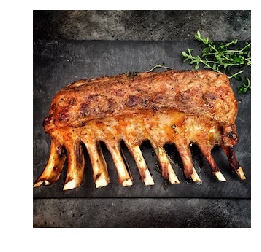

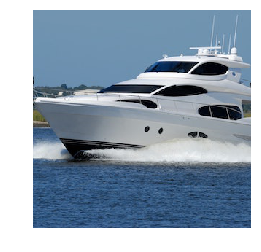

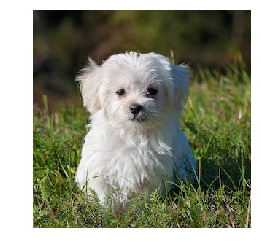

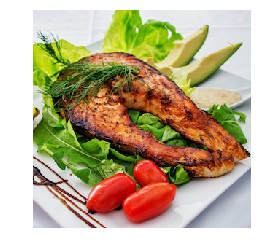

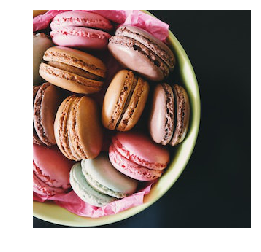

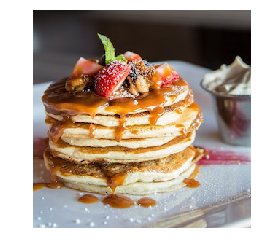

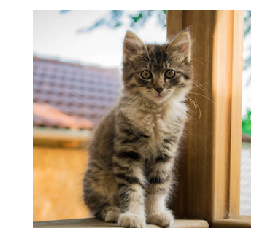

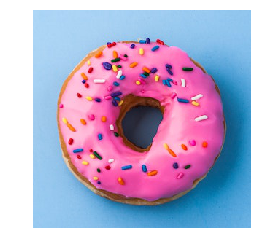

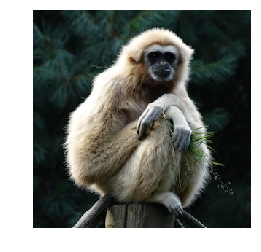

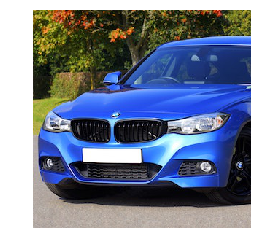

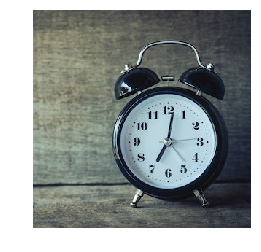

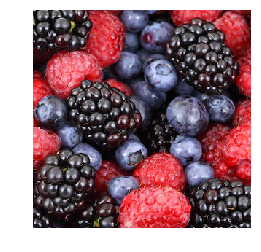

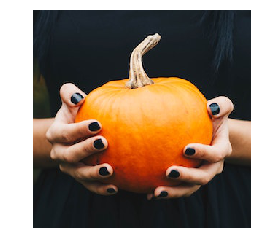

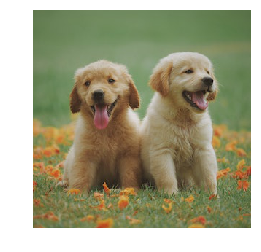

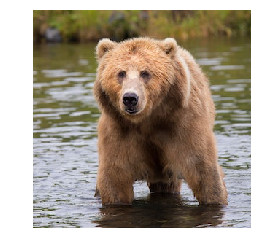

In [3]:
img_dir = 'images/'

# Specify image dimensions
size = 299

# Load model
model = InceptionV3(weights = 'imagenet')

# Load images
all_images = {}
for filename in os.listdir(img_dir):
    if not filename.startswith('.'):
        img = image.load_img(img_dir + filename, target_size = (size, size)) # We assume all images have the same dimensions
        img = image.img_to_array(img)
        all_images[filename.split('.')[0]] = img

# Display images
for key, vals in all_images.items():
    fig2 = plt.figure()
    plt.axis('off')
    plt.imshow(vals.astype(np.uint8))

# Gabor Noise

In [4]:
grid = 23 # fixed grid size

# Interactive slider
def PlotGaborRand(img_key, max_norm, num_kern, ksize, sigma, theta, lambd, color = 'Black-White'):
    image = all_images[img_key]
    fig = plt.figure(figsize = (18, 7.5))
    plt.subplots_adjust(wspace = 0.05)
    plt.title('Anisotropic Gabor Noise', size = 20)
    plt.axis('off')
    
    if color == 'Black-White': coloring = [1, 1, 1]
    if color == 'Red-Cyan': coloring = [1, -1, -1]
    if color == 'Green-Magenta': coloring = [-1, 1, -1]
    if color == 'Blue-Yellow': coloring = [-1, -1, 1]
    
    # Noise pattern
    ax = fig.add_subplot(1, 3, 3)    
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis = 'both', which = 'both', length = 0)
    ax.set_title('Noise Pattern', size = 16)
    
    noise = gaborN_rand(size = size, grid = grid, num_kern = num_kern, ksize = ksize, sigma = sigma, theta = theta, lambd = lambd)
    noise = normalize_var(noise)
    noise = colorize(noise, coloring)
    plt.imshow(normalize(noise))
    
    # Original image
    ax = fig.add_subplot(1, 3, 1)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis = 'both', which = 'both', length = 0)
    ax.set_title('Original Image', size = 16)
    payload = perturb(img = image, noise = np.zeros((size, size, 3)), norm = max_norm)
    plt.imshow(payload.astype(np.uint8))
    prob = model.predict(preprocess_input(payload.astype(np.float).reshape((1, size, size, 3))))
    plt.xlabel('\n'.join((item[1]  + '  %.3f' % item[2]) for item in decode_predictions(prob)[0]), horizontalalignment = 'right', x = 1, size = 16)
    
    # Altered image
    ax = fig.add_subplot(1, 3, 2)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis = 'both', which = 'both', length = 0)
    ax.set_title('Altered Image', size = 16)
    payload = perturb(img = image, noise = noise, norm = max_norm)
    plt.imshow(payload.astype(np.uint8))
    prob = model.predict(preprocess_input(payload.astype(np.float).reshape((1, size, size, 3))))
    plt.xlabel('\n'.join((item[1]  + '  %.3f' % item[2]) for item in decode_predictions(prob)[0]), horizontalalignment = 'right', x = 1, size = 16)

# Parameter sliders
s_img_key = Dropdown(options = list(all_images.keys()), value = 'boat', description = 'Image:')
s_max_norm = IntSlider(min = 0, max = 64, value = 12, step = 2, continuous_update = False, description = 'Max Change:')
s_num_kern = IntSlider(min = 1, max = 100, value = 23, step = 1, continuous_update = False, description = 'No. Kernels:')
s_ksize = IntSlider(min = 1, max = 100, value = 23, step = 1, continuous_update = False, description = 'Kernel Size:')
s_sigma = FloatSlider(min = 1, max = 20, value = 8, step = 0.25, continuous_update = False, description = 'Kernel Var:')
s_theta = FloatSlider(min = 0, max = np.pi, value = np.pi / 4, step = np.pi / 24, continuous_update = False, description = 'Orientation:')
s_lambd = FloatSlider(min = 0.25, max = 20, value = 8, step = 0.25, continuous_update = False, description = 'Bandwidth:')
s_color = ToggleButtons(options = ['Black-White', 'Red-Cyan', 'Green-Magenta', 'Blue-Yellow'], description = 'Color:', button_style='', disabled = False)

interactive(PlotGaborRand,
                 img_key = s_img_key,
                 max_norm = s_max_norm,
                 num_kern = s_num_kern,
                 ksize = s_ksize,
                 sigma = s_sigma,
                 theta = s_theta,
                 lambd = s_lambd,
                 color = s_color)

interactive(children=(Dropdown(description='Image:', index=1, options=('bbq', 'boat', 'maltese_dog', 'salmon',…

The classifier's top 5 predictions are displayed under each image.